In [1]:
from lbmpy.session import *
from pystencils.slicing import add_ghost_layers, remove_ghost_layers
from lbmpy.relaxationrates import lattice_viscosity_from_relaxation_rate, relaxation_rate_from_lattice_viscosity


def discrete_l2_norm_by_number_of_nodes(field):
    squared_sum = np.sqrt(np.sum(field ** 2, axis=-1))
    return np.linalg.norm(squared_sum) / np.sqrt(squared_sum.size)


def discrete_linf_norm(field):
    return np.max(np.abs(field))


def add_flipped_on_top(field):
    flipped = np.copy(field)
    flipped[:, :, 1] *= -1
    flipped = np.flipud(flipped)
    return np.concatenate([field, flipped], axis=1)


def get_lower_half(field):
    assert field.shape[1] % 2 == 0
    return field[:, :field.shape[1]//2, :]

# Stokes flow - comparison to an analytical solution

This notebook sets up a periodic scenario with a given force field where the analytical (Stokes) solution is known. The simualted results are compared to the analytical solution.

### Analytic part

In [2]:
sym_x, sym_y, sym_mu = sp.symbols("x y mu")
sym_k = sp.symbols("k", integer=True)

Definition of stream function:

In [3]:
potential = sp.sin(sym_k * sym_x) * sp.sin(sym_y)
potential

Velocity field as curl of stream function

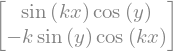

In [4]:
sym_vel = sp.Matrix([sp.diff(potential, sym_y), -sp.diff(potential, sym_x)])
sym_vel

Definition of pressure field

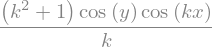

In [5]:
p = (sym_k ** 2 + 1) * sp.cos(sym_k * sym_x) * sp.cos(sym_y) / sym_k
p

Compute force field (for variable viscosities)

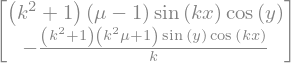

In [6]:
def laplacian(term):
    return sp.diff(term, sym_x, sym_x) + sp.diff(term, sym_y, sym_y)    


symForce = sp.Matrix([- sym_mu * laplacian(sym_vel[0]) + sp.diff(p, sym_x),
                      - sym_mu * laplacian(sym_vel[1]) + sp.diff(p, sym_y)])
symForce = sp.simplify(symForce)
symForce

In [7]:
def get_field_from_term(start, end, points, term):
    """Get a numpy array from a symbolic description."""
    xc, yc = np.meshgrid(np.linspace(start[0], end[0], points[0]),
                         np.linspace(start[1], end[1], points[1]), indexing='ij')    
    result = np.zeros(tuple(points) + (2,))
    result[:, :, 0] = sp.lambdify([sym_x, sym_y], term[0], 'numpy')(xc, yc)
    result[:, :, 1] = sp.lambdify([sym_x, sym_y], term[1], 'numpy')(xc, yc)
    return result

### Non-dimensionalization

Parameters

In [8]:
cells = 100
domain_size = np.pi
k = 2
mu = 1
density = 0.1
relaxation_rate = 1.2
method = Method.SRT
force_model = ForceModel.GUO

In [9]:
replacements = {sym_mu: mu, sym_k: k}

dx = domain_size / cells
dm = dx**3 * density
nu_l = lattice_viscosity_from_relaxation_rate(relaxation_rate)
nu_phy = mu / density
dt = nu_l / nu_phy * dx**2
forceFactor = dt**2 * dx**2 / dm
vel_factor = dt / dx
Re = vel_factor * cells / nu_l

print("Force factor", forceFactor)
print("VelFactor   ", vel_factor)
print("dx          ", dx)
print("dt          ", dt)
print("Re          ", Re)

Force factor 3.827935392629609e-08
VelFactor    0.000349065850398866
dx           0.031415926535897934
dt           1.0966227112321513e-05
Re           0.3141592653589793


### Setting up velocity field:|

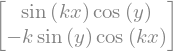

In [10]:
sym_vel

### Setting up force field:


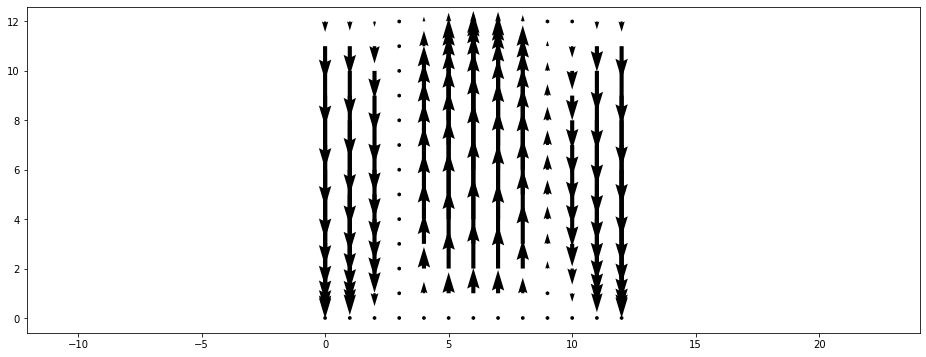

In [11]:
def get_force_field(start, end, points):
    x, y = np.meshgrid(np.linspace(start[0], end[0], points[0]),
                       np.linspace(start[1], end[1], points[1]), indexing='ij')
    force_val = np.zeros(tuple(points) + (2,))
    force_val[:, :, 1] = -(np.cos(k * x) * np.sin(y) * (k ** 4 + 2 * k * k + 1)) / k
    return force_val


force = get_field_from_term((dx / 2, dx / 2), (np.pi - dx / 2, np.pi - dx / 2), [cells, cells],
                            symForce.subs(replacements)) * forceFactor

plt.vector_field(force, step=8)
np.max(force)

In [12]:
offset = dx / 2
analytical_solution = get_field_from_term(start=(offset, offset),
                                          end=(np.pi - offset, np.pi - offset),
                                          points=[cells, cells],
                                          term=sym_vel.subs(replacements))


### Scenario set up:

In [13]:
force = force.copy(order='F')
forceWithGl = add_ghost_layers(force, index_dimensions=1)
forceField = Field.create_from_numpy_array('forceArr', forceWithGl, index_dimensions=1)
initialVelocity = analytical_solution / dx * dt

sc = create_fully_periodic_flow(initial_velocity=initialVelocity, method=method,
                                force=(0, forceField(1)), force_model=force_model,
                                kernel_params={'forceArr': forceWithGl},
                                relaxation_rate=relaxation_rate,
                                compressible=False, equilibrium_order=1)


In [14]:
# Vastiew generated code
# show_code(sc.ast)

### Boundary set up:

In [15]:
pi = np.pi
repl_sym_vel = sym_vel.subs(replacements)
vel_x_lambda = sp.lambdify([sym_x, sym_y], repl_sym_vel[0], 'numpy')
vel_y_lambda = sp.lambdify([sym_x, sym_y], repl_sym_vel[1], 'numpy')

offset = 0  # 0.5*dx

ubb_arr = np.zeros((cells + 2, cells + 2, 2))
# Left Border
ubb_arr[0, 1:-1, 0] = vel_x_lambda(offset, np.arange(0.5 * dx, pi, dx))
ubb_arr[0, 1:-1, 1] = vel_y_lambda(offset, np.arange(0.5 * dx, pi, dx))
# Right Border
ubb_arr[-1, 1:-1, 0] = vel_x_lambda(pi - offset, np.arange(0.5 * dx, pi, dx))
ubb_arr[-1, 1:-1, 1] = vel_y_lambda(pi - offset, np.arange(0.5 * dx, pi, dx))
# Lower Border
ubb_arr[1:-1, 0, 0] = vel_x_lambda(np.arange(0.5 * dx, pi, dx), offset)
ubb_arr[1:-1, 0, 1] = vel_y_lambda(np.arange(0.5 * dx, pi, dx), offset)
# Upper Border
ubb_arr[1:-1, -1, 0] = vel_x_lambda(np.arange(0.5 * dx, pi, dx), pi - offset)
ubb_arr[1:-1, -1, 1] = vel_y_lambda(np.arange(0.5 * dx, pi, dx), pi - offset)


ubb_arr[0, 0, 0] = vel_x_lambda(offset, offset)
ubb_arr[0, 0, 1] = vel_y_lambda(offset, offset)

ubb_arr[0, -1, 0] = vel_x_lambda(offset, pi - offset)
ubb_arr[0, -1, 1] = vel_y_lambda(offset, pi - offset)

ubb_arr[-1, 0, 0] = vel_x_lambda(pi - offset, offset)
ubb_arr[-1, 0, 1] = vel_y_lambda(pi - offset, offset)

ubb_arr[-1, -1, 0] = vel_x_lambda(pi - offset, pi - offset)
ubb_arr[-1, -1, 1] = vel_y_lambda(pi - offset, pi - offset)

ubb_arr *= vel_factor

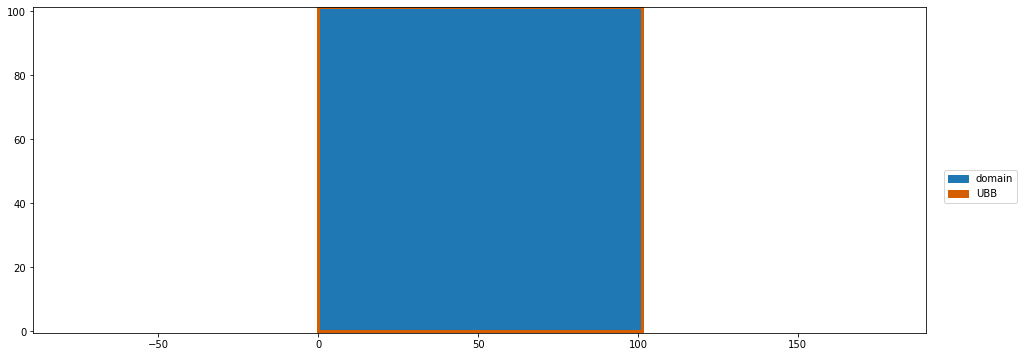

In [16]:
from lbmpy.boundaries import UBB, NoSlip
from pystencils.slicing import slice_from_direction

velField = Field.create_from_numpy_array('ubbField', ubb_arr, index_dimensions=1)
myUbb = UBB(velocity=(velField(0), velField(1)), adapt_velocity_to_force=True)

for direction in ('W', 'E', 'S', 'N'):
    sc.boundary_handling.set_boundary(myUbb, slice_from_direction(direction, dim=2))

plt.boundary_handling(sc.boundary_handling)

sc.kernel_params['ubbField'] = ubb_arr

## Run

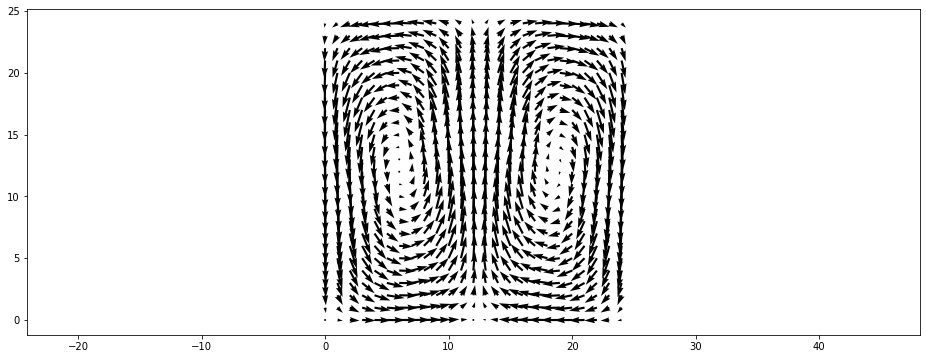

In [17]:
sc.run(20000)
plt.vector_field(sc.velocity[:, :], step=4);
np.max(sc.velocity[:, :])

In [18]:
simulated_solution = sc.velocity[:, :] * dx / dt
l2_norm = discrete_l2_norm_by_number_of_nodes(simulated_solution - analytical_solution)
inf_norm = discrete_linf_norm(simulated_solution - analytical_solution)
assert l2_norm < 0.008
assert inf_norm < 0.11
print("L2  Error", l2_norm)
print("Inf Error", inf_norm)

L2  Error 0.007035092839725868
Inf Error 0.010440166565636733


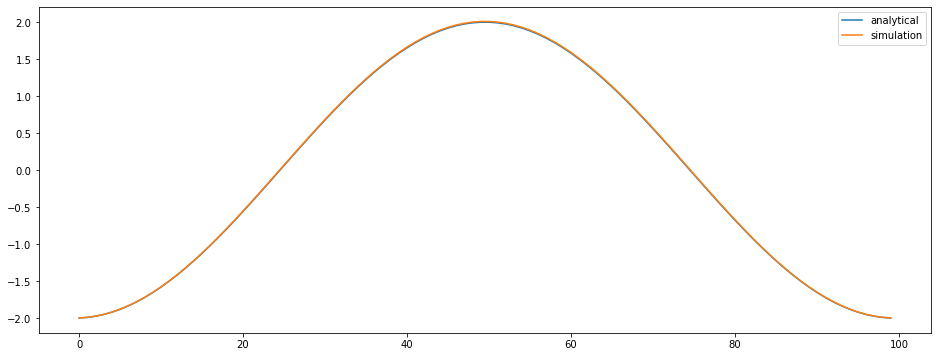

In [19]:
plt.plot(analytical_solution[:, cells // 2, 1], label='analytical')
plt.plot(simulated_solution[:, cells // 2, 1], label='simulation')
plt.legend();

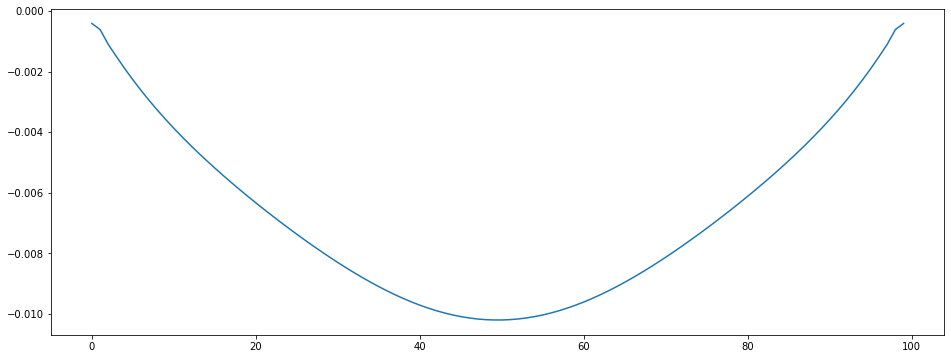

In [20]:
diff = analytical_solution - simulated_solution
plt.plot(diff[:, cells//2, 1]);

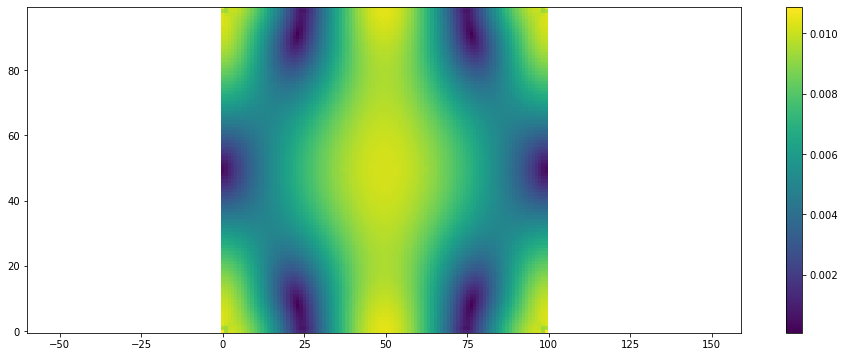

In [21]:
plt.vector_field_magnitude(simulated_solution - analytical_solution)
plt.colorbar();

# Periodic version

In [22]:
force_p = add_flipped_on_top(force)

analytical_solution_p = get_field_from_term((0, 0), (pi - dx, pi - dx), [cells, cells], sym_vel.subs(replacements))
analytical_solution_p = add_flipped_on_top(analytical_solution_p)

force_with_gl_p = add_ghost_layers(force_p, index_dimensions=1)
forceField = Field.create_from_numpy_array('forceArr', force_with_gl_p, index_dimensions=1)
initial_velocity_p = analytical_solution_p / dx * dt

sc_p = create_fully_periodic_flow(initial_velocity=initial_velocity_p, method=method,
                                  force=(0, forceField(1)), force_model=force_model,
                                  kernel_params={'forceArr': force_with_gl_p},
                                  relaxation_rate=relaxation_rate,
                                  equilibrium_order=1)

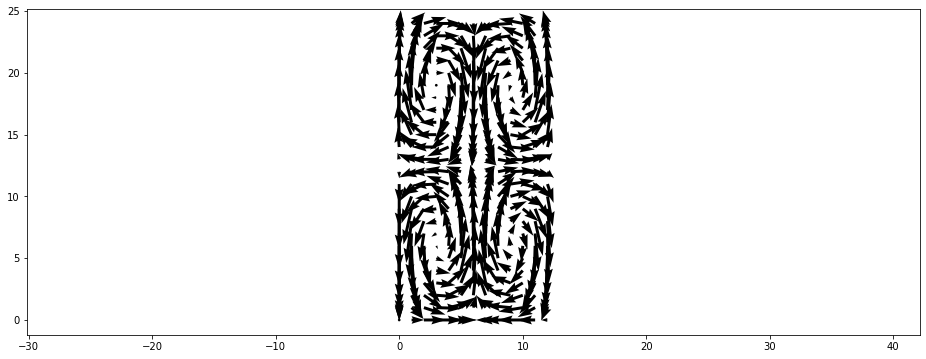

In [23]:
plt.vector_field(analytical_solution_p, step=8);

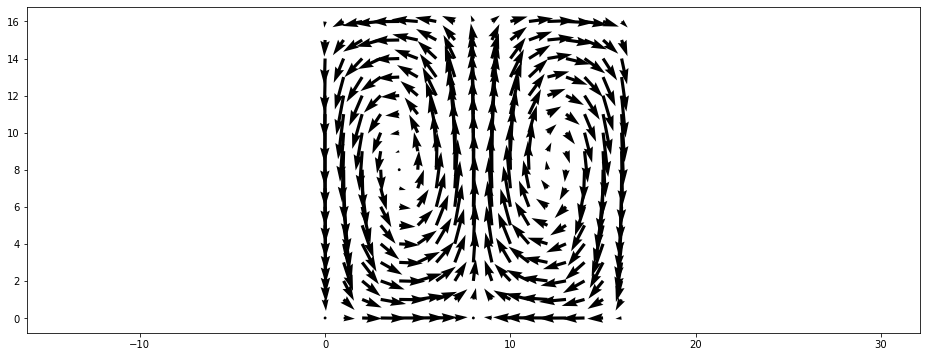

In [24]:
sc_p.run(50_000)
plt.vector_field(get_lower_half(sc_p.velocity[:, :]), step=6);

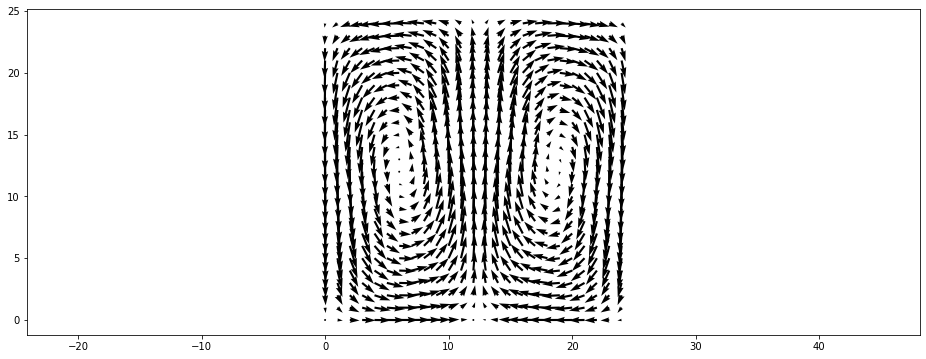

In [25]:
simulated_solution = get_lower_half(sc_p.velocity[:, :]) * dx / dt
plt.vector_field(simulated_solution, step=4);

In [26]:
l2_norm = discrete_l2_norm_by_number_of_nodes(simulated_solution - analytical_solution)
inf_norm = discrete_linf_norm(simulated_solution - analytical_solution)
assert l2_norm < 4e-4
assert inf_norm < 7e-4
print("L2  Error", l2_norm)
print("Inf Error", inf_norm)

L2  Error 0.0003661754381671058
Inf Error 0.0006321865492990852


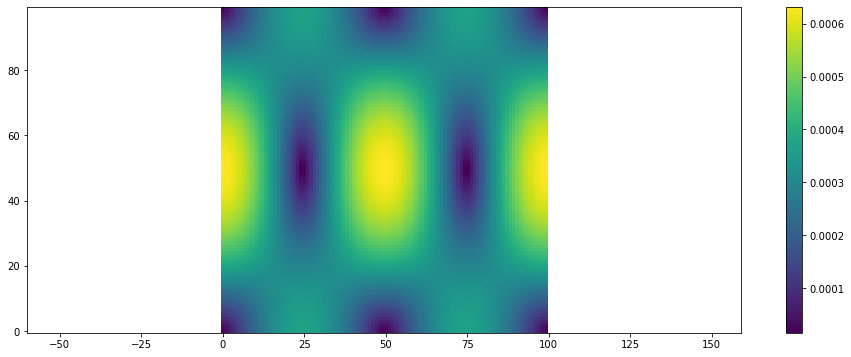

In [27]:
plt.vector_field_magnitude(simulated_solution - analytical_solution)
plt.colorbar();